<a href="https://colab.research.google.com/github/crash13205/P2P-RL/blob/main/ESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gym
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pylab as plt
import random
import math
import pickle
from gym.utils import seeding
from gym import spaces


In [ ]:

#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
db = pd.read_excel('/content/DB.xlsx',sheet_name="Database_New",usecols ='A:F')
print(db)

      Hour  YearDay     LBMP  Solar_pu   Load_pu   Heat_pu
0        0        0  0.03076       0.0  0.493387  0.270588
1        1        0  0.03188       0.0  0.470213  0.296210
2        2        0  0.03242       0.0  0.451643  0.302049
3        3        0  0.03213       0.0  0.440317  0.341201
4        4        0  0.03057       0.0  0.437712  0.344079
...    ...      ...      ...       ...       ...       ...
8755    19      360  0.16769       0.0  0.749543  0.383821
8756    20      360  0.17769       0.0  0.727979  0.405691
8757    21      360  0.14953       0.0  0.701755  0.418552
8758    22      360  0.13094       0.0  0.675670  0.429506
8759    23      360  0.13245       0.0  0.648861  0.444059

[8760 rows x 6 columns]


In [ ]:
class SSEnv(gym.Env):

    def __init__(self):
        self.observation_space = spaces.Box(low = -1, high = 1, shape = (2,), dtype = np.float32)
        self.action_range = [0,0.2,0.4,0.6,0.8,1,-0.2,-0.4,-0.6,-0.8,-1]
        self.action_space = spaces.Discrete(11)

        self.ep_len=len(db)
        self.ep_steps = 24
        self.test = False
        self.test_idx = 1704


        self.reg_factor =  0.01
        self.es_factor = 15
        self.eta_batt = 0.95
        self.eta_psh = 0.8

#%% Random number generation. Initialization with seed

    def seed(self,seed=0):
        self.np_random, seed=seeding.np_random(seed)
        return [seed]

#%%
    def step(self,action): # positive action: discharge, negative: charge

        self.reward = 0
        self.reward -= self.reg_factor*(action)**2

########################################################################################
        eta = self.eta_batt

# i,e: battery charge and discharge are from -Pmax to +Pmax (the learned action is in this limit)
        action = self.action_range[action]*self.Pmax

        if (self.E1 +  action / self.eta_batt ) < 0: # charge
            action = -1* self.E1 * self.eta_batt

        if (self.E1 + action * self.eta_batt ) > self.Emax: # discharge
            action = (self.Emax - self.E1) / self.eta_batt

        self.E1 += max(0,action)*eta + min(0,action)/eta # updating storage (charged and discharged quantities update here as E1)

        self.reward -= self.es_factor * action * (self.lmp - self.lmp_mean )/ self.lmp_mean  # reward charging when price is low

        if action >= 0:
            self.pch_storage1_alltime.append(action)
            self.pdch_storage1_alltime.append(0)
        else:
            self.pdch_storage1_alltime.append(action)
            self.pch_storage1_alltime.append(0)

        self.actual_reward += self.reward


        self.device = 0
        self.idx += 1
        self.counter += 1
        if self.idx < self.ep_len-25 and self.counter < self.ep_steps:
            self.lmp =   db['LBMP'][self.idx]
            self.lmp_mean = np.average(db['LBMP'][self.idx:self.idx + 24])
        else:
            self.episode_end = True


        return self._get_obs(), self.reward, self.episode_end, {}

    def reset(self):
        self.counter = 0
        self.Pmax = 100
        self.Emax = 600


        if self.test:
            self.idx = self.test_idx
            self.E1 = 0.5*self.Emax
        else:
            self.idx = np.random.randint(len(db)-100)
            self.E1 = (np.random.random())*self.Emax

        # LBMP= Locational Based Marginal Pricing
        self.lmp = db['LBMP'][self.idx]
        self.lmp_mean =  np.average(db['LBMP'][self.idx:self.idx + 24])



        self.pch_storage1_alltime = []
        self.pdch_storage1_alltime = []


        self.device = 0
        self.episode_end = False
        self.actual_reward = 0
        self.reserve = 0
        self.cost = 0


        return self._get_obs()


    def _get_obs(self): #The states component of the system

        return np.array([(self.lmp - self.lmp_mean)/self.lmp_mean] + [self.E1/self.Emax])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = SSEnv()
env.not_storage = False
env.reset()

array([0.56650455, 0.13730183])

In [ ]:
!pip install stable_baselines3
from stable_baselines3 import DQN

In [ ]:
!pip install shimmy>=0.2.1

In [ ]:
import time

# Start timer
start_time = time.time()

###################Training#####################

model = DQN("MlpPolicy", env, verbose=1)

#for i in range(2):
model.learn(total_timesteps= 60000, log_interval=10)#, callback=callback
model.save("ESS-DQN")
##########################################

# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -956     |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 3391     |
|    time_elapsed     | 0        |
|    total_timesteps  | 240      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -439     |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 3568     |
|    time_elapsed     | 0        |
|    total_timesteps  | 480      |
----------------------------------


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -766     |
|    exploration_rate | 0.886    |
| time/               |          |
|    episodes         | 30       |
|    fps              | 3611     |
|    time_elapsed     | 0        |
|    total_timesteps  | 720      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -959     |
|    exploration_rate | 0.848    |
| time/               |          |
|    episodes         | 40       |
|    fps              | 3597     |
|    time_elapsed     | 0        |
|    total_timesteps  | 960      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -451     |
|    exploration_rate | 0.81     |
| time/               |          |
|    episodes       

In [ ]:
model = DQN.load("ESS-DQN")

obs = env.reset()

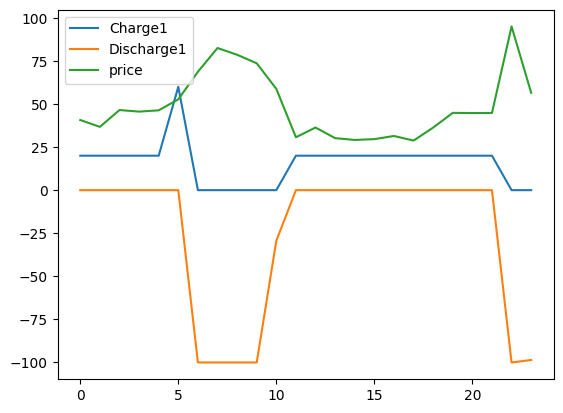

8168.491049722779


In [ ]:
env.test=True

obs = env.reset()

for i in range(24):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, dones, info = env.step(action)
#    print(reward)
    price_range = 1000*db['LBMP'][env.test_idx:env.test_idx + 24].reset_index(drop=True)
    if i==23:
        plt.plot(env.pch_storage1_alltime)
        plt.plot(env.pdch_storage1_alltime)
        plt.plot(price_range)

        plt.legend(["Charge1", "Discharge1","price",])
        plt.show()


print(env.actual_reward)